In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

import pyopencl as cl
import pyopencl.array as cl_array
import PyNetwork
from PyNetwork.gpu.GPUNN import GPUOPERATOR

### Matrix Mulplication Time Comparison

- GPU 1d
- GPU 2d
- GPU 2d with local memory
- numpy

In [3]:
code = """
    #define BLOCK_SIZE 16
    #define A_BLOCK_STRIDE (BLOCK_SIZE * a_width)
    #define A_T_BLOCK_STRIDE (BLOCK_SIZE * a_height)
    
    __kernel void matrixmultiply1d(int heightA, int widthA, int heightB, int widthB, __global float *A, __global float *B, __global float *out){
        int index = get_global_id(0);
        int Arow = index / widthB;
        int Bcol = index % widthB;
        float sum = 0.0f;
        for (int i = 0; i < widthA; i++){
            sum += A[Arow * widthA + i] * B[i * widthB + Bcol];
        }
        out[index] = sum;
    }

    __kernel void matrixmultiply2d(int heightA, int widthA, int heightB, int widthB, __global float *A, __global float *B, __global float *out){
        int row = get_global_id(1);
        int col = get_global_id(0);
    
        float sum = 0.0f;
        for (int i=0; i < widthA; i++){
            sum += A[row * widthA + i] * B[i * widthB + col];
        }

        out[row*widthB + col] = sum;
    }

    __kernel void matrixmultiply2dlocal(int heightA, int widthA, int heightB, int widthB, __global float *A, __global float *B, __global float *out){
        int local_row = get_local_id(1);
        int local_col = get_local_id(0);

        int row = get_global_id(1);
        int col = get_global_id(0);

        __local float Ab[BLOCK_SIZE][BLOCK_SIZE];
        __local float Bb[BLOCK_SIZE][BLOCK_SIZE];

        int num = widthA / BLOCK_SIZE;
        float sum = 0.0f;
        
        for (int n=0; n < num; n++){
            int row_b = n*BLOCK_SIZE + local_row;
            int col_b = n*BLOCK_SIZE + local_col;

            Ab[local_row][local_col] = A[row*widthA + col_b];
            Bb[local_row][local_col] = B[row_b*widthB + col];

            barrier(CLK_LOCAL_MEM_FENCE);  

            for (int i=0; i < BLOCK_SIZE; i++){
                sum += Ab[local_row][i] * Bb[i][local_col];
            }  

            barrier(CLK_LOCAL_MEM_FENCE);    
        }

        out[row*widthB + col] = sum;
    }
"""

In [21]:
platform = cl.get_platforms()
devices = platform[0].get_devices()
context = cl.Context(devices)
queue = cl.CommandQueue(context)

m, n, p = 2**11, 2**10, 2**11
A = np.random.rand(m, n).astype(np.float32)
B = np.random.rand(n, p).astype(np.float32)
C = np.empty((m, p), dtype=np.float32)
size = m * p

BLOCK_SIZE = 16
local_size = (BLOCK_SIZE, BLOCK_SIZE)

A_gpu = cl_array.to_device(queue, A)
B_gpu = cl_array.to_device(queue, B)
out_gpu = cl_array.to_device(queue, C)

program = cl.Program(context, code).build()

In [22]:
%%timeit -r 7 -n 100
A @ B

28.2 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit -r 7 -n 100
program.matrixmultiply1d(queue, (size, ), None, 
                np.int32(m), np.int32(n), np.int32(n), np.int32(p), A_gpu.data, B_gpu.data, out_gpu.data)

1.26 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%%timeit -r 7 -n 100
program.matrixmultiply2d(queue, (m, p), None, 
                np.int32(m), np.int32(n), np.int32(n),  np.int32(p), A_gpu.data, B_gpu.data, out_gpu.data)

2.12 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


: 

In [29]:
%%timeit -r 7 -n 100
program.matrixmultiply2dlocal(queue, (m, p), local_size, 
                np.int32(m), np.int32(n), np.int32(n), np.int32(p), A_gpu.data, B_gpu.data, out_gpu.data)

1.72 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
platform = cl.get_platforms()
devices = platform[0].get_devices()
context = cl.Context(devices)
queue = cl.CommandQueue(context)

BLOCK_SIZE = 16
local_size = (BLOCK_SIZE, BLOCK_SIZE)


program = cl.Program(context, code).build()



def computation_time_for_cpu_matmal(A, B):
    start = time.time()
    out = A @ B
    end = time.time()

    return end - start

def computation_time_for_gpu_matmal1d(A_gpu, B_gpu, out_gpu):
    size = n * n
    start = time.time()
    event = program.matrixmultiply1d(queue, (size, ), None, 
                np.int32(n), np.int32(n), np.int32(n), np.int32(n), A_gpu.data, B_gpu.data, out_gpu.data)
    end = time.time()

    return end - start

def computation_time_for_gpu_matmal2d(A_gpu, B_gpu, out_gpu):
    start = time.time()
    event = program.matrixmultiply2d(queue, (n, n), None, 
                np.int32(n), np.int32(n), np.int32(n),  np.int32(n), A_gpu.data, B_gpu.data, out_gpu.data)
    end = time.time()

    return end - start

def computation_time_for_gpu_matmal2dlocal(A_gpu, B_gpu, out_gpu):
    start = time.time()
    event = program.matrixmultiply2dlocal(queue, (n, n), local_size, 
                np.int32(n), np.int32(n), np.int32(n), np.int32(n), A_gpu.data, B_gpu.data, out_gpu.data)
    end = time.time()

    return end - start

In [8]:
n_vals = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12]
num_trials = 20
#cpu_times = []
gpu1d_times = []
gpu2d_times = []
gpu2dlocal_times = []


for n in n_vals:
    A = np.random.rand(n, n).astype(np.float32)
    B = np.random.rand(n, n).astype(np.float32)
    C = np.empty((n, n), dtype=np.float32)

    A_gpu = cl_array.to_device(queue, A)
    b_gpu = cl_array.to_device(queue, B)
    out_gpu = cl_array.to_device(queue, C)

    #average_cpu_time = np.mean([computation_time_for_cpu_matmal(A, B) for _ in range(num_trials)])
    average_gpu1d_time = np.mean([computation_time_for_gpu_matmal1d(A_gpu, b_gpu, out_gpu) for _ in range(num_trials)])
    average_gpu2d_time = np.mean([computation_time_for_gpu_matmal2d(A_gpu, b_gpu, out_gpu) for _ in range(num_trials)])
    average_gpu2dlocal_time = np.mean([computation_time_for_gpu_matmal2dlocal(A_gpu, b_gpu, out_gpu) for _ in range(num_trials)])

    #cpu_times.append(average_cpu_time)
    gpu1d_times.append(average_gpu1d_time)
    gpu2d_times.append(average_gpu2d_time)
    gpu2dlocal_times.append(average_gpu2dlocal_time)

: 

: 

Text(0.5, 0, 'Square Matrix shape')

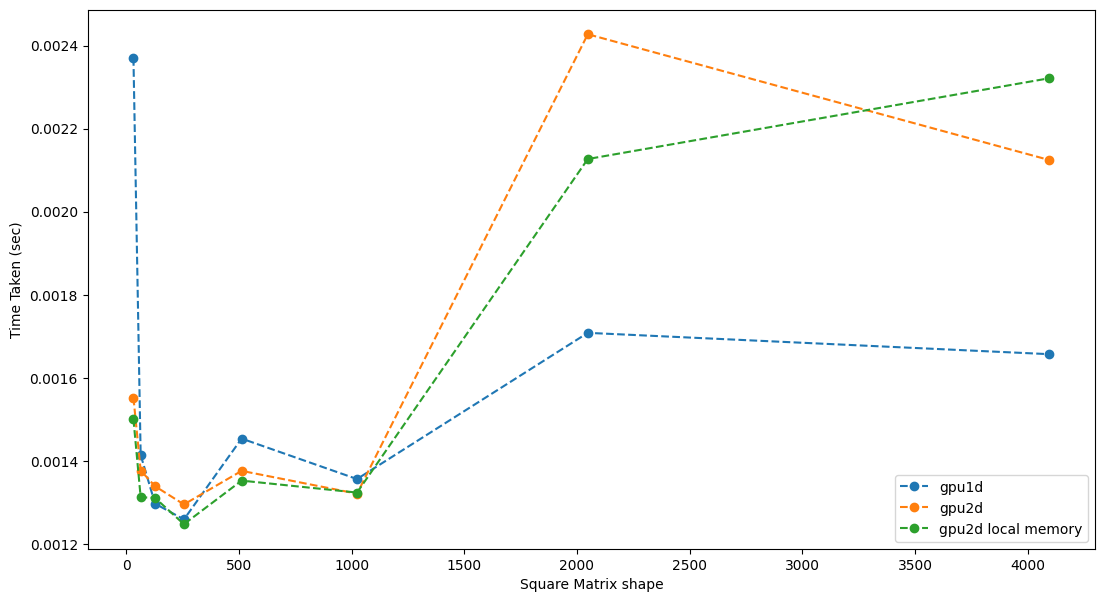

In [7]:
plt.figure(figsize=(13, 7))
# plt.plot(n_vals, cpu_times, 'o--', label='cpu')
plt.plot(n_vals, gpu1d_times, 'o--', label='gpu1d')
plt.plot(n_vals, gpu2d_times, 'o--', label='gpu2d')
plt.plot(n_vals, gpu2dlocal_times, 'o--', label='gpu2d local memory')
plt.legend()
plt.ylabel('Time Taken (sec)')
plt.xlabel('Square Matrix shape')